# Выделение нестационарных режимов с помощью приращений

In [1]:
from math import nan

In [2]:
import numpy as np
from scipy.optimize import minimize
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

In [3]:
from utils import TARGET_FEATURE, FIGSIZE, DATAFILE_NAMES, RANDOM_SEED, load_all, train_split_stratified, target_split, mode_sequencer
from features import *
from baseline import baseline_classification_score, baseline_clusterization_score

In [4]:
dfs = load_all()
dfs_pca = [t_pca(df, 0.99) for df in dfs]

## Первый взгляд на приращения

В данном пункте строятся графики отсортированных суммарных приращений по всем признакам для разных наборов данных.

In [5]:
# for idfs in (dfs, dfs_pca):
#     print()
#     for df in idfs:
#         df, _ = target_split(df)
#         df = (df - df.min()) / (df.max() - df.min())
#         _, ax = plt.subplots(figsize=FIGSIZE)
#         q = (0.3, 0.999)
#         tmean = (df.sum(axis=1) / df.shape[1]).diff().abs()
#         kwargs = {'ax': ax, 'logx': True, 'logy': True}
#         tmean.sort_values().reset_index(drop=True).iloc[int(df.shape[0] * q[0]):int(df.shape[0] * q[1])].plot(**kwargs)
#         tmean.rolling(5).mean().sort_values().reset_index(drop=True).iloc[int(df.shape[0] * q[0]):int(df.shape[0] * q[1])].plot(**kwargs)
#         tmean.rolling(5).max().sort_values().reset_index(drop=True).iloc[int(df.shape[0] * q[0]):int(df.shape[0] * q[1])].plot(**kwargs)

#         df0 = f_derivative(df)
#         df0 = df0[[x for x in df0.columns if 'der' in x]].abs()
#         df0.sum(axis=1).sort_values().reset_index(drop=True).iloc[int(df.shape[0] * q[0]):int(df.shape[0] * q[1])].plot(**kwargs)

#         plt.show()

## Второй взгляд на приращения

В данном пункте строятся графики отсортированных суммарных приращений первых по величине модуля `k` признаков и последних по величине модуля `n` признаков для разных наборов данных. Также оценивается насколько точно по этим кривым можно разбить режимы на две категории: стационарные и нестационарные.

In [6]:
# def temp(edge, t0, target):
#     """ определение точности разбиения на стационарные/нестационарные режимы
#         на основе известного таргета и уставки по величине приращения """
#     t00 = (t0 > edge).astype(int)
#     res1, res2 = 0, 0
#     res3, res4 = 0, 0
#     for mode in target.unique():
#         t = target[target == mode]
#         t = t00.loc[t.index].value_counts()
#         res1 += t.iloc[0]
#         res2 += t.iloc[1] if len(t) > 1 else 0
#         res3 += t.loc[1] if 1 in t.index else 0
#     return res2 / res1, res1, res2

# for idfs in (dfs, dfs_pca):
#     print()
#     for df in idfs:
#         print('new df')
#         df, target = target_split(df.dropna())
#         df = (df - df.min()) / (df.max() - df.min())
#         _, ax = plt.subplots(figsize=FIGSIZE)
#         kwargs = {'ax': ax, 'logx': False, 'logy': True}
#         q = (0.01, 1)
#         n = 2
#         k = 2
#         tmax = pd.DataFrame(np.sort(df.diff().abs().values, axis=1), index=df.index).iloc[:, -n:].sum(axis=1) / n
#         tmax.sort_values().reset_index(drop=True).iloc[int(df.shape[0] * q[0]):int(df.shape[0] * q[1])].plot(**kwargs)
#         tmax.rolling(5).mean().sort_values().reset_index(drop=True).iloc[int(df.shape[0] * q[0]):int(df.shape[0] * q[1])].plot(**kwargs)
#         tmax.rolling(5).max().sort_values().reset_index(drop=True).iloc[int(df.shape[0] * q[0]):int(df.shape[0] * q[1])].plot(**kwargs)

#         tmin = pd.DataFrame(np.sort(df.diff().abs().replace(0, df.max().max()).values, axis=1), index=df.index).iloc[:, :k].sum(axis=1) / k
#         tmin.sort_values().reset_index(drop=True).iloc[int(df.shape[0] * q[0]):int(df.shape[0] * q[1])].plot(**kwargs)
#         tmin.rolling(5).mean().sort_values().reset_index(drop=True).iloc[int(df.shape[0] * q[0]):int(df.shape[0] * q[1])].plot(**kwargs)
#         tmin.rolling(5).max().sort_values().reset_index(drop=True).iloc[int(df.shape[0] * q[0]):int(df.shape[0] * q[1])].plot(**kwargs)

#         ax.set_xlabel('Номер строки после сортировки')
#         ax.set_ylabel('Величина приращения')
#         plt.show()

#         points = 100
#         _, ax = plt.subplots(figsize=FIGSIZE)
#         edge = np.linspace(tmax.min(), tmax.max(), points)
#         ax.plot(edge, [y if y != 0 else nan for y in [temp(x, tmax, target)[0] for x in edge]])
#         edge = np.linspace(tmin.min(), tmin.max(), points)
#         ax.plot(edge, [y if y != 0 else nan for y in [temp(x, tmin, target)[0] for x in edge]])
#         ax.set_xlabel('Величина граничного значения приращения\nдля отнесения к стационарному/нестационарному режимам')
#         ax.set_ylabel('Доля неправильно определенных точек режимов')
#         plt.show()

#         _, ax = plt.subplots(figsize=FIGSIZE)
#         edge = np.linspace(tmax.min(), tmax.max(), points)
#         ax.plot(edge, [temp(x, tmax, target)[1] for x in edge])
#         ax.plot(edge, [temp(x, tmax, target)[2] for x in edge])

#         edge = np.linspace(tmin.min(), tmin.max(), points)
#         ax.plot(edge, [temp(x, tmin, target)[1] for x in edge])
#         ax.plot(edge, [temp(x, tmin, target)[2] for x in edge])
#         ax.set_yscale('log')
#         ax.set_xlabel('Величина граничного значения приращения\nдля отнесения к стационарному/нестационарному режимам')
#         ax.set_ylabel('Количество попадающих/непопадающих\nв определенные режимы точек')
#         plt.show()

Теперь проблема выделить те приращения, которые имеют отношение к переходным режимам.

## Третий взгляд на приращения

В данном пункте строятся violin plot для приращений внутри каждого режима.

In [7]:
# for idfs in (dfs, dfs_pca):
#     print('Новая группа данных')
#     for df in idfs:
#         print('Новый набор данных')
#         df, target = target_split(df.dropna())
#         df = (df - df.min()) / (df.max() - df.min())

#         q = (0.01, 1)
#         n = 2
#         k = 2
#         df0 = df.diff().abs()
#         tmean = df0.sum(axis=1) / df.shape[1]
#         tmax = pd.DataFrame(np.sort(df0.values, axis=1), index=df.index).iloc[:, -n:].sum(axis=1) / n
#         tmin = pd.DataFrame(np.sort(df0.replace(0, df.max().max()).values, axis=1), index=df.index).iloc[:, :k].sum(axis=1) / k

#         t = pd.concat([tmin, tmean, tmax, target], axis=1)

#         modes = sorted(target.unique())

#         _, ax = plt.subplots(figsize=FIGSIZE)
#         ax.violinplot(dataset=[t[t[TARGET_FEATURE] == mode][0].values for mode in modes]);

#         _, ax = plt.subplots(figsize=FIGSIZE)
#         ax.violinplot(dataset=[t[t[TARGET_FEATURE] == mode][1].values for mode in modes])

#         _, ax = plt.subplots(figsize=FIGSIZE)
#         ax.violinplot(dataset=[t[t[TARGET_FEATURE] == mode][2].values for mode in modes])
        
#         plt.show()

Очевидно, что разные режимы по оцениваемым параметрам не различаются. Дальше анализировать данные смысла нет.

## Четвертый взгляд на приращения

Предобработка с помощью t_discrete.

In [8]:
# for df in dfs:
#     print('Новый набор данных')
#     df = df.dropna()
#     df = t_discrete(t_pca(df, 0.999), 100, True)
#     df, target = target_split(df)

#     q = (0.01, 1)
#     n = 2
#     k = 2
#     df0 = df.diff().abs()
#     tmean = df0.sum(axis=1) / df.shape[1]
#     tmax = pd.DataFrame(np.sort(df0.values, axis=1), index=df.index).iloc[:, -n:].sum(axis=1) / n
#     tmin = pd.DataFrame(np.sort(df0.replace(0, df.max().max()).values, axis=1), index=df.index).iloc[:, :k].sum(axis=1) / k

#     t = pd.concat([tmin, tmean, tmax, target], axis=1)

#     modes = sorted(target.unique())

#     _, ax = plt.subplots(figsize=FIGSIZE)
#     ax.violinplot(dataset=[t[t[TARGET_FEATURE] == mode][0].values for mode in modes]);

#     _, ax = plt.subplots(figsize=FIGSIZE)
#     ax.violinplot(dataset=[t[t[TARGET_FEATURE] == mode][1].values for mode in modes])

#     _, ax = plt.subplots(figsize=FIGSIZE)
#     ax.violinplot(dataset=[t[t[TARGET_FEATURE] == mode][2].values for mode in modes])

#     plt.show()

## Пятый взгляд на приращения

,min,mean,median,max
target,,,,
1.0,0,0.347826,0.0,6
2.0,0,4.562500,5.0,10
3.0,0,0.000000,0.0,0
4.0,0,4.656250,5.0,9
5.0,0,0.000000,0.0,0
6.0,1,4.520000,5.0,7
7.0,0,0.777778,0.0,4
8.0,0,4.722222,4.0,8
10.0,1,5.250000,6.0,10


(-0.5, 10.0)

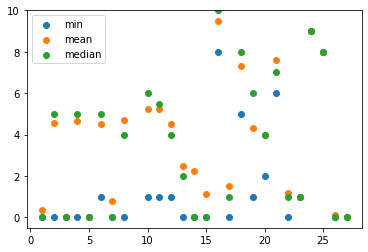

In [9]:
df = dfs[0]
df = df.dropna()
df = t_discrete(t_pca(df, 0.999))
res = pd.concat([target_split(mode)[0].diff().mean() for mode in mode_sequencer(df)], axis=1).T
# res = (res != 0).sum(axis=1)
res[res.abs() < 0.1] = 0
# res1 = res.abs().sum(axis=1)
res1 = (res != 0).sum(axis=1)
res1 = pd.concat([res1, pd.Series([mode[TARGET_FEATURE].iloc[0] for mode in mode_sequencer(df)], name=TARGET_FEATURE)], axis=1)
#(res != 0).sum(axis=1).value_counts()
r = res1.groupby(TARGET_FEATURE).agg([min, np.mean, np.median, max])[0]
display(r)
_, ax = plt.subplots()
for col in r:
    if col not in ['max']:
        ax.scatter(r.index, r[col], label=col)
ax.legend()
ax.set_ylim((-0.5, 10))

In [10]:
# res1 = pd.DataFrame([(target_split(mode)[1].iloc[0], target_split(mode)[0].diff().std().mean()) for mode in mode_sequencer(df)])
# res1 = res1.groupby(0).agg([min, np.mean, max])
# _, ax = plt.subplots()
# ax.scatter(res1.index, res1[1]['mean'], label='mean')
# ax.scatter(res1.index, res1[1]['min'], label='min')
# ax.scatter(res1.index, res1[1]['max'], label='max')
# ax.legend()

Судя по всему нестационарные режимы можно выявить путем анализа количества изменяющихся признаков.